# Assignment 4 - Vanilla RNN

## Libraries

In [9]:
import math

import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm.notebook import trange

In [10]:
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_properties(i).name)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Data

In [11]:
book_fname = 'data/goblet_book.txt'
with open(book_fname, 'r') as f:
    book_data = f.read()
    f.close()

book_chars = list(set(book_data))
K = len(book_chars)
print(f"Number of unique characters: {K}")
char2ind, ind2char = dict(), dict()
for i, c in enumerate(book_chars):
    char2ind[c] = i
    ind2char[i] = c

Number of unique characters: 80


## Model

In [12]:
class RNN:

    def __init__(self, m=100, seq_length=25, eta=.001, gamma=.9, sig=.01, device=device):
        self.m = m
        self.seq_length = seq_length
        self.eta = eta
        self.gamma = gamma
        self.device = device

        self.V = torch.randn(K, m).to(self.device) * sig
        self.c = torch.zeros(K, 1).to(self.device)
        self.W = torch.randn(m, m).to(self.device) * sig
        self.b = torch.zeros(m, 1).to(self.device)
        self.U = torch.randn(m, K).to(self.device) * sig

        self.V_g_ada = torch.zeros(K, m).to(self.device)
        self.c_g_ada = torch.zeros(K, 1).to(self.device)
        self.W_g_ada = torch.zeros(m, m).to(self.device)
        self.b_g_ada = torch.zeros(m, 1).to(self.device)
        self.U_g_ada = torch.zeros(m, K).to(self.device)

        self.V_best = self.V.clone()
        self.c_best = self.c.clone()
        self.W_best = self.W.clone()
        self.b_best = self.b.clone()
        self.U_best = self.U.clone()

        self.smooth_losses = list()

        self.grads = {
            'V': torch.zeros_like(self.V),
            'c': torch.zeros_like(self.c),
            'W': torch.zeros_like(self.W),
            'b': torch.zeros_like(self.b),
            'U': torch.zeros_like(self.U)
        }

    def synthesize(self, h_prev, x, n, best=False):
        Y = torch.zeros((K, n)).to(self.device)
        x_t = x
        for i in range(n):
            h_prev, p = self.forward(h_prev, x_t, best=best)
            cp = torch.cumsum(p, dim=0)
            r = torch.rand(1)
            for j in range(K):
                if r < cp[j]:
                    break
            Y[j, i] = 1
            x_t = torch.zeros((K, 1))
            x_t[j] = 1
        return Y

    def forward(self, h_prev, x, best=False):
        if not best:
            h = torch.tanh(self.W @ h_prev + self.U @ x + self.b)
            y = self.V @ h + self.c
            p = torch.softmax(y, dim=0)
        else:
            h = torch.tanh(self.W_best @ h_prev + self.U_best @ x + self.b_best)
            y = self.V_best @ h + self.c_best
            p = torch.softmax(y, dim=0)
        return h, p
    
    def forward_pass(self, h_0, X, Y, best=False):
        h = h_0
        H = torch.zeros((self.m, self.seq_length + 1)).to(self.device)
        P = torch.zeros((K, self.seq_length)).to(self.device)
        H[:, 0] = h.flatten()
        loss = 0
        for i in range(self.seq_length):
            h, p = self.forward(h, X[:, i].reshape(K, 1), best=best)
            H[:, i+1] = h.flatten()
            P[:, i] = p.flatten()
            loss += self.loss(p, Y[:, i].reshape(K, 1))
        return H, P, loss

    def backward_pass(self, H, P, X, Y):
        self.grads = {
            'V': torch.zeros_like(self.V),
            'c': torch.zeros_like(self.c),
            'W': torch.zeros_like(self.W),
            'b': torch.zeros_like(self.b),
            'U': torch.zeros_like(self.U)
        }
        dL_dh_next = torch.zeros((self.m, 1)).to(self.device)
        h0 = H[:, 0].reshape(self.m, 1)
        H = H[:, 1:]
        for i in range(self.seq_length-1, -1, -1):
            x = X[:, i].reshape(K, 1)
            y = Y[:, i].reshape(K, 1)
            h = H[:, i].reshape(self.m, 1)
            p = P[:, i].reshape(K, 1)
            g = (p - y).T
            self.grads['V'] += g.T @ h.T
            self.grads['c'] += g.T
            dL_dh = self.V.T @ g.T + self.W.T @ dL_dh_next
            dL_dh_next = dL_dh * (1 - h ** 2)
            self.grads['W'] += dL_dh_next @ H[:, i-1].reshape(1, self.m) if i != 0 else dL_dh_next @ h0.T
            self.grads['b'] += dL_dh_next
            self.grads['U'] += dL_dh_next @ x.T
    
    def update_params(self, eps=1e-16):
        for key in self.grads.keys():
            self.grads[key] = torch.clamp(self.grads[key], -5, 5)
            vars(self)[key + '_g_ada'] = self.gamma * vars(self)[key + '_g_ada'] + (1 - self.gamma) * self.grads[key] ** 2
            vars(self)[key] -= self.eta * self.grads[key] / torch.sqrt(vars(self)[key + '_g_ada'] + eps)


    def loss(self, p, y):
        return - torch.sum(y.T @ torch.log(p))

    def train(self, book_data, n_epochs=7, eps=1e-16):
        n_iter = 0
        smooth_loss = 0
        best_loss = torch.inf
        pbar = trange(n_epochs)
        for epoch in pbar:
            pbar.set_description(f"Epoch {epoch}/{n_epochs}")
            self.e = 0
            h = torch.zeros((self.m, 1)).to(self.device)
            while self.e + self.seq_length <= len(book_data):
                X_chars = book_data[self.e:self.e+self.seq_length]
                Y_chars = book_data[self.e+1:self.e+self.seq_length+1]
                X = torch.zeros((K, self.seq_length)).to(self.device)
                Y = torch.zeros((K, self.seq_length)).to(self.device)
                for i in range(self.seq_length):
                    X[char2ind[X_chars[i]], i] = 1
                    Y[char2ind[Y_chars[i]], i] = 1

                H, P, loss = self.forward_pass(h, X, Y)
                self.backward_pass(H, P, X, Y)
                self.update_params(eps)

                smooth_loss = .999 * smooth_loss + .001 * loss if smooth_loss != 0 else loss
                self.smooth_losses.append(smooth_loss)

                if smooth_loss < best_loss:
                    best_loss = smooth_loss
                    self.V_best = self.V.clone()
                    self.c_best = self.c.clone()
                    self.W_best = self.W.clone()
                    self.b_best = self.b.clone()
                    self.U_best = self.U.clone()

                h = H[:, -1].reshape(self.m, 1)

                n_iter += 1
                if n_iter % 1000 == 0:
                    print(
                        f"Training - Iteration {n_iter} - Loss {smooth_loss}")
                    
                if n_iter % 10000 == 0:
                    Y = self.synthesize(h, X[:, 0].reshape(K, 1), 200)
                    print()
                    print(''.join([ind2char[torch.argmax(Y[:, i]).item()] for i in range(200)]))
                    print()

                self.e += self.seq_length

        print(f"Training done - Best loss: {best_loss}")

    def check_grads(self, book_data):
        for key in self.grads.keys():
            vars(self)[key].requires_grad = True

        X_chars = book_data[:self.seq_length]
        Y_chars = book_data[1:self.seq_length+1]
        X = torch.zeros((K, self.seq_length)).to(self.device)
        Y = torch.zeros((K, self.seq_length)).to(self.device)
        h0 = torch.zeros((self.m, 1)).to(self.device)
        for i in range(self.seq_length):
            X[char2ind[X_chars[i]], i] = 1
            Y[char2ind[Y_chars[i]], i] = 1

        H, P, loss = self.forward_pass(h0, X, Y)
        self.backward_pass(H, P, X, Y)

        for key in self.grads.keys():
            vars(self)[key].retain_grad()
        loss.backward()

        print("Checking gradients")
        with torch.no_grad():
            for key in self.grads.keys():
                diff = torch.norm(self.grads[key] - vars(self)[key].grad)
                rel_err = diff / (torch.norm(self.grads[key]) + torch.norm(vars(self)[key].grad) + 1e-16)
                print(f"Relative error on {key}: {rel_err}")

    def plot_losses(self):
        plt.plot(self.smooth_losses)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Smoothed loss')
        plt.show()

In [13]:
rnn = RNN()
rnn.check_grads(book_data)

Checking gradients
Relative error on V: 2.41572895021136e-08
Relative error on c: 2.6179758805255915e-08
Relative error on W: 4.325439562080646e-08
Relative error on b: 3.737445553042562e-08
Relative error on U: 2.973572144071568e-08


In [14]:
rnn = RNN()
rnn.train(book_data, n_epochs=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Training - Iteration 1000 - Loss 84.29646301269531
Training - Iteration 2000 - Loss 70.2965316772461
Training - Iteration 3000 - Loss 63.12345886230469
Training - Iteration 4000 - Loss 60.032535552978516
Training - Iteration 5000 - Loss 58.26274108886719
Training - Iteration 6000 - Loss 57.67570495605469
Training - Iteration 7000 - Loss 57.29396438598633
Training - Iteration 8000 - Loss 54.99694061279297
Training - Iteration 9000 - Loss 54.12350845336914
Training - Iteration 10000 - Loss 53.94949722290039

thus wave he toound Could in tra yo?" thinge yo's got Hempling of oun i!"
sas ant got.M "bHarre las toedargentther hey ser ther koy Hormy peartinn aigll's sheromers, sand the tinding shat aid coums," 

Training - Iteration 11000 - Loss 54.53718566894531
Training - Iteration 12000 - Loss 53.878273010253906
Training - Iteration 13000 - Loss 53.06559371948242
Training - Iteration 14000 - Loss 52.29709243774414
Training - Iteration 15000 - Loss 52.3012580871582
Training - Iteration 16000

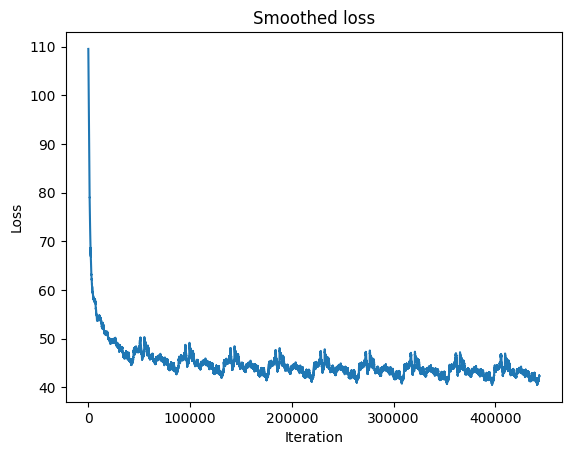

In [15]:
rnn.plot_losses()

In [16]:
starting_char = 'H'
X = torch.zeros((K, 1)).to(device)
X[char2ind[starting_char], 0] = 1
h = torch.zeros((rnn.m, 1)).to(device)
Y = rnn.synthesize(h, X, 1000, best=True)
print(starting_char + ''.join([ind2char[torch.argmax(Y[:, i]).item()] for i in range(1000)]))

Haent the edgeent off 
mi meut on to kill."
ro that wahal of thest it that him was gold now, and Harry told to she his newst and Harry, under reace fathering there, Harry," Harry detting this edgening yourt Dumbledgrtaira, the drommaneways were streach we a menticirway," said use twarep his read, and he was and trie, hand, bess ascold here want one of the faning eye.  hinding corgact disgurned still got ittannoy for its let to we tonam knew them into the now and had virius you,"" his mot might at that staiting and almogious for not off, as happened to drame brealoudely , he s cent let.  irvis on dim sens will invescoing to him, shorred, and piaved," said Dumbledore bemorect, and it oncreturt of roldoning.   his wand like it was at anst had misting eyes well over knownish's well wath as he reoum to none said aching enside on the profestle down though what 
le to himself, and thofting Dark you aite sbrewing as e,  the pleas . . . . he shout.  He one office, his mouto ianet was eyes towil